In [55]:
from sympy import *
from IPython.display import display, Math
import numpy as np
init_printing(use_unicode=True)
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

In [26]:
from sympy import solve
x, y, s, C, sigma, mu, delta, alpha, beta, ro, eta, b, lambd = symbols(
    'x y s C σ μ δ α β ρ η b λ')

In [27]:
dxdt = x*(1-x) - (b/(1+s*x))*(1-exp(-ro*C))*x

In [28]:
display(Math('\dfrac{dx}{dt} = ' + latex(dxdt)))

<IPython.core.display.Math object>

In [29]:
def get_next(x0, params):
    return x0 + dxdt.evalf(subs=(params|{x:x0}))

In [30]:
def get_k_next_by_c(curx, cur_params, cs):
    r = []
    for cur_c in cs:
        r.append(float(curx))
        curx = get_next(curx, cur_params | {C:cur_c})
    return r   

### Равновесия в зависимости от С


#### Аналитическое решение

In [45]:

params = {s:0.1, b:1.0, ro:1}
an_sols = solve(dxdt.subs(params), x)
an_sols

In [32]:
zero_sol = an_sols[0]#0
x_star1_sol = an_sols[2] 
# решение с отрицательным х отбросили
zero_sol, x_star1_sol

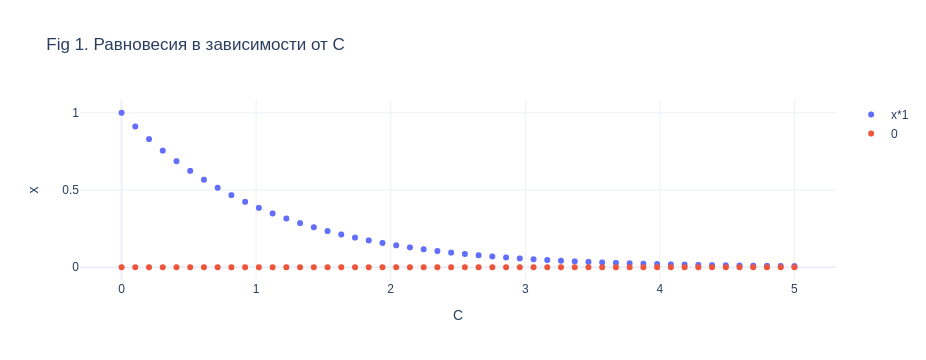

In [11]:
params = {s:0.1, b:1.0, ro:1}
#Norton-Simon hypothesis is negligible
cs = []
xs =[]
sols_by_c = {}
for cur_C in np.linspace(0,5,50):
    curx = x_star1_sol.subs(C, cur_C)
    cs.append(float(cur_C))
    xs.append(float(curx))
        
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=cs, y=xs, mode='markers', name = "x*1"))
fig.add_trace(go.Scatter(x=cs, y=[0]*len(cs), mode='markers', name = "0"))
fig.update_layout(title="Fig 1. Равновесия в зависимости от С", template="plotly_white")
fig.update_layout(xaxis={"title": "C"}, yaxis={"title": "x"})

In [12]:
cs_brown = [0]*50 + [5]*150
cs_green = [0]*50 + [1]*150
cs_blue = [0]*50 + [0.2]*150

In [13]:

s_par = 0.1
b_par = 1.0

params = {s:s_par, b:b_par, ro:1}
ts = list(np.linspace(0,200, 201))
xs_brown = get_k_next_by_c(1, params, cs_brown)
xs_green = get_k_next_by_c(1, params, cs_green)
xs_blue = get_k_next_by_c(1, params, cs_blue)                          

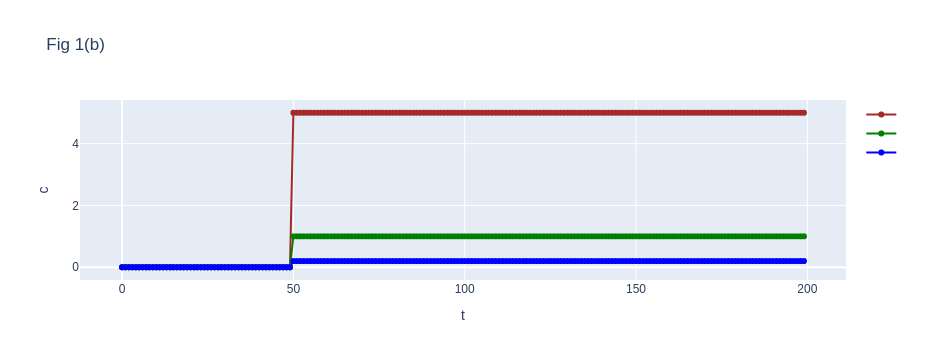

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts, y=cs_brown, mode='lines+markers', line=dict(color="brown"), name = ""))
fig.add_trace(go.Scatter(x=ts, y=cs_green, mode='lines+markers', line=dict(color="green"), name = ""))
fig.add_trace(go.Scatter(x=ts, y=cs_blue, mode='lines+markers', line=dict(color="blue"), name = ""))
fig.update_layout(title="Fig 1(b)")
fig.update_layout(xaxis={"title": "t"}, yaxis={"title": "c"})

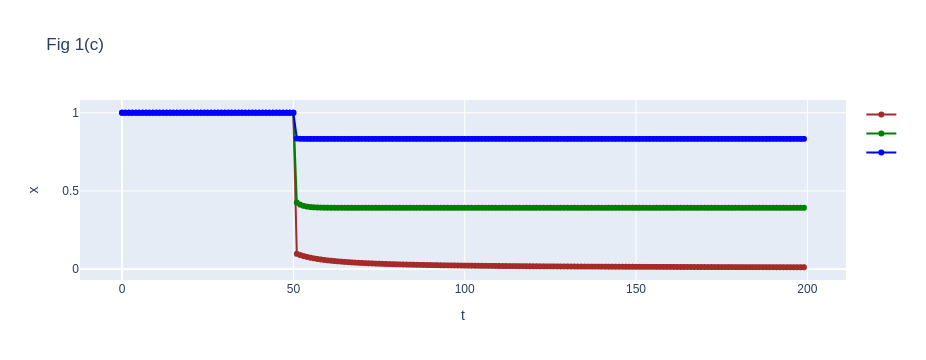

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts, y=xs_brown, mode='lines+markers', line=dict(color="brown"), name = ""))
fig.add_trace(go.Scatter(x=ts, y=xs_green, mode='lines+markers', line=dict(color="green"), name = ""))
fig.add_trace(go.Scatter(x=ts, y=xs_blue, mode='lines+markers', line=dict(color="blue"), name = ""))
fig.update_layout(title="Fig 1(c)")
fig.update_layout(xaxis={"title": "t"}, yaxis={"title": "x"})

In [16]:
def get_k_next(curx, k, cur_params):
    r = []
    for i in range(k):
        r.append(float(curx))
        curx = get_next(curx, cur_params)
    return r     

In [17]:
def get_arrow_scatter(cur_C, k, curx, cur_params, shift):
    return go.Scatter(x=[cur_C]*k, y=get_k_next(curx+shift, k, cur_params),  mode="lines+markers",
            marker=dict(
                symbol="arrow",
                size=10,
                color='green',
                angleref="previous",
            ), name = "")

In [43]:
s_par = 2
b_par = 1
params = {ro:1}
an_sol = solve(dxdt.subs(params), x)
an_sol

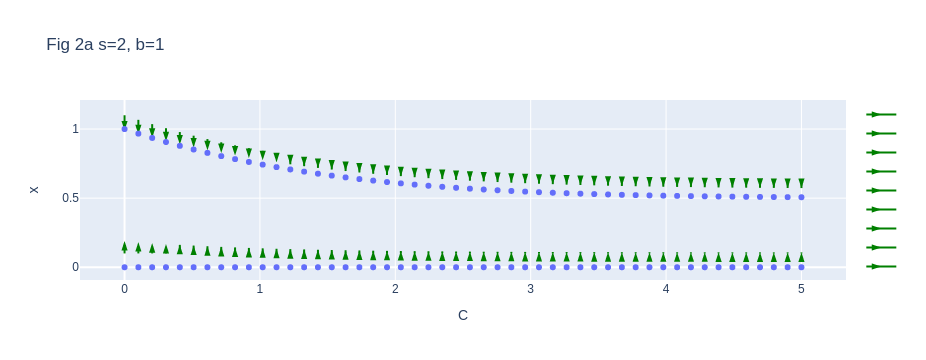

In [18]:
s_par = 2
b_par = 1
params = {s:s_par, b:b_par, ro:1}

cs = []
xs =[]
sols_by_c = {}
fig = go.Figure()

for cur_C in np.linspace(0,5,50):
    cur_params = {C:cur_C} | params
    sols_by_c[cur_C] = [sol for sol in solve(dxdt.subs(cur_params), x)
                       if sol.is_real and sol >=0]
    for curx in sols_by_c[cur_C]:
        cs.append(float(cur_C))
        xs.append(float(curx))
        k = 2# number of steps
        fig.add_trace(get_arrow_scatter(cur_C, k, curx, cur_params, shift = 0.1))
        
    
fig.add_trace(go.Scatter(x=cs, y=xs, mode='markers', name = ""))
fig.update_layout(title=f"Fig 2a s={s_par}, b={b_par}")
fig.update_layout(xaxis={"title": "C"}, yaxis={"title": "x"})

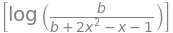

In [37]:
s_par = 2
b_par = 1.1
params = {s:s_par, ro:1}

solve(dxdt.subs(params), C)

In [61]:
def is_stable(c, x, cur_params) -> bool:
    """Запускаем траекторию из точки вблизи от равновесия. Если точка осталась в этой окрестости, 
    то аттрактор"""
    k=10
    for shift in [-0.01,0.01, -0.1,0.1]:
        x_start = x+shift
        if x_start<0:
            continue
        x_fin = get_k_next(x_start, k, cur_params)[-1]
        return abs(x_fin - x_start) < shift
        

In [68]:
def get_attr_rep(cs, xs, cur_params):
    stables = []
    for c, x in zip(cs, xs):
        stables.append(is_stable(c,x,cur_params | {C:c}))
    res = []
    th = list(zip(cs, xs, stables))
    prev_is_stable = th[0][2]
    cur_subsegment = []
    for c, x, st in th:
        if st == prev_is_stable:
            cur_subsegment.append((c, x, st))
        else:
            res.append(cur_subsegment)
            cur_subsegment = []
            cur_subsegment.append((c, x, st))
            prev_is_stable = st
    res.append(cur_subsegment)
    return res

In [69]:

an_sols

In [88]:
def get_line_mode(cont_subsegment):
    return {} if cont_subsegment[0][2] else {"dash":"dot"}

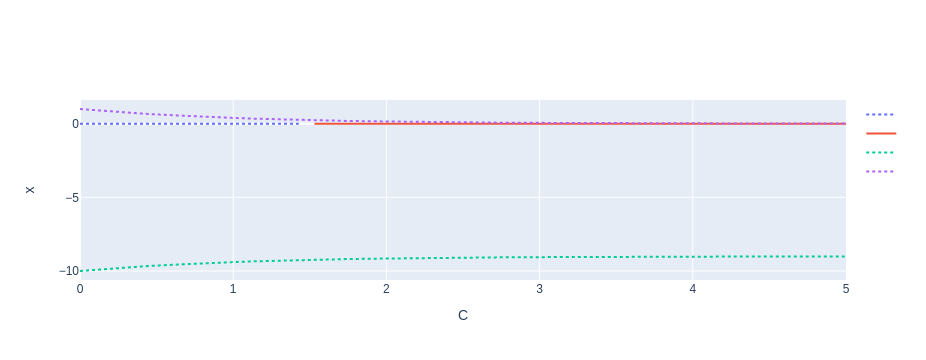

In [90]:
s_par = 2
b_par = 1.1
params = {s:s_par, b:b_par, ro:1}

cs = []
xs =[]
sols_by_c = {}
fig = go.Figure()

cs = list(np.linspace(0,5,50))
df = pd.DataFrame({"c":cs})
for an_sol in an_sols:
    xs = [float(an_sol.subs({C:c} | params)) for c in cs]
    # fig.add_trace(go.Scatter(x=cs, y=xs, mode='markers', name = ""))
    for cont_subsegment in get_attr_rep(cs, xs, cur_params):
        fig.add_trace(go.Scatter(x=[c for (c,_,_) in cont_subsegment],
                                 y=[x for (_,x,_) in cont_subsegment],
                                 mode="lines",
                                 name = "",
                                 line=get_line_mode(cont_subsegment)))
        
    
# for cur_C in np.linspace(0,5,50):
#     cur_params = {C:cur_C} | params
#     sols_by_c[cur_C] = [sol for sol in solve(dxdt.subs(cur_params), x)
#                        if sol>=0]
#     for curx in sols_by_c[cur_C]:
#         cs.append(float(cur_C))
#         xs.append(float(curx))
#         k = 2# number of steps
#         fig.add_trace(get_arrow_scatter(cur_C, k, curx, cur_params, shift = 0.02))
        
    
# fig.add_trace(go.Scatter(x=cs, y=xs, mode='markers', name = ""))
# fig.update_layout(title=f"Fig 2b s={s_par}, b={b_par}")
fig.update_layout(xaxis={"title": "C"}, yaxis={"title": "x"})

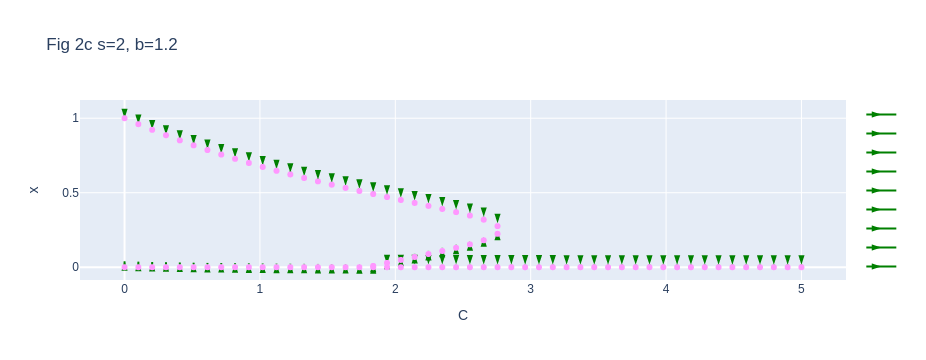

In [72]:
s_par = 2
b_par = 1.2
params = {s:s_par, b:b_par, ro:1}
#### NOTE: отбросили комплексные решения

cs = []
xs =[]
sols_by_c = {}
fig = go.Figure()

for cur_C in np.linspace(0,5,50):
    cur_params = {C:cur_C} | params
    sols_by_c[cur_C] = [sol for sol in solve(dxdt.subs(cur_params), x)
                       if sol.is_real and sol >=0]
    for curx in sols_by_c[cur_C]:
        cs.append(float(cur_C))
        xs.append(float(curx))
        k = 2# number of steps
        fig.add_trace(get_arrow_scatter(cur_C, k, curx, cur_params, shift = 0.02))
        
    
fig.add_trace(go.Scatter(x=cs, y=xs, mode='markers', name = ""))
fig.update_layout(title=f"Fig 2c s={s_par}, b={b_par}")
fig.update_layout(xaxis={"title": "C"}, yaxis={"title": "x"})


In [21]:
def display_sol_dict(sol_dict):
    for cur_c, sols in sol_dict.items():
        print(f"C = {cur_c}")
        display(sols)
        display("*"*20)

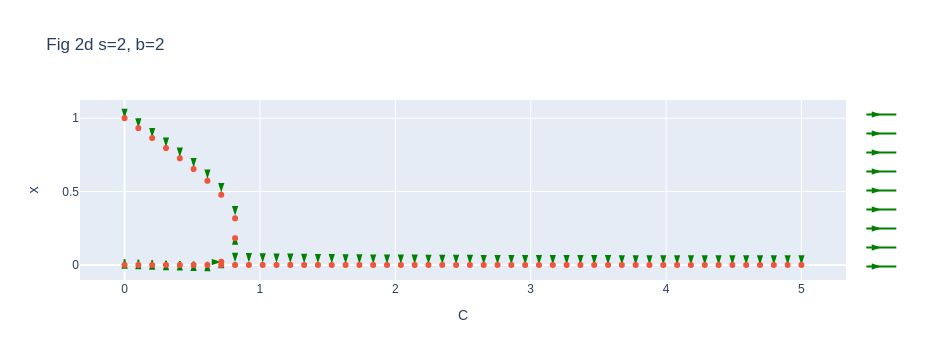

In [22]:
s_par = 2
b_par = 2
params = {s:s_par, b:b_par, ro:1}
#### NOTE: отбросили комплексные решения

cs = []
xs =[]
sols_by_c = {}
fig = go.Figure()

for cur_C in np.linspace(0,5,50):
    cur_params = {C:cur_C} | params
    sols_by_c[cur_C] = [sol for sol in solve(dxdt.subs(cur_params), x)
                       if sol.is_real and sol >=0]
    for curx in sols_by_c[cur_C]:
        cs.append(float(cur_C))
        xs.append(float(curx))
        k = 2# number of steps
        fig.add_trace(get_arrow_scatter(cur_C, k, curx, cur_params, shift = 0.02))
        
    
fig.add_trace(go.Scatter(x=cs, y=xs, mode='markers', name = ""))
fig.update_layout(title=f"Fig 2d s={s_par}, b={b_par}")
fig.update_layout(xaxis={"title": "C"}, yaxis={"title": "x"})

In [23]:
s_par = 2
b_par = 1.2

params = {s:s_par, b:b_par, ro:1}
cs_smart_protocol = [0]*50 + [3]*100 + [2] * 100
# ts = list(np.linspace(0,len(cs_smart_protocol), len(cs_smart_protocol)))
ts = list(range(len(cs_smart_protocol)))

xs_smart_protocol = get_k_next_by_c(1, params, cs_smart_protocol)

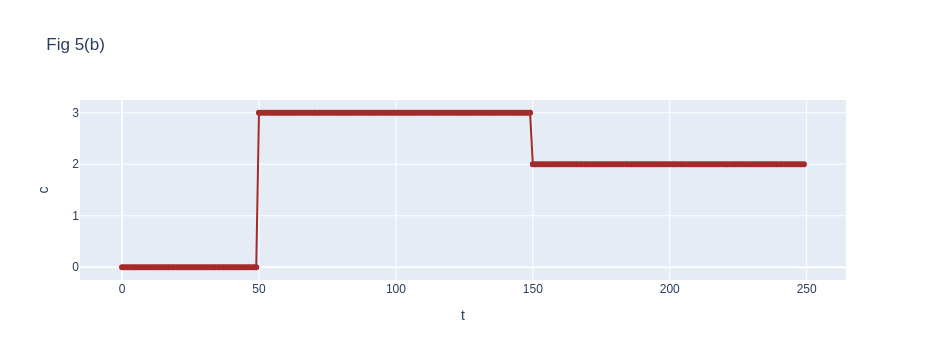

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts, y=cs_smart_protocol, mode='lines+markers', line=dict(color="brown"), name = ""))
fig.update_layout(title="Fig 5(b)")
fig.update_layout(xaxis={"title": "t"}, yaxis={"title": "c"})

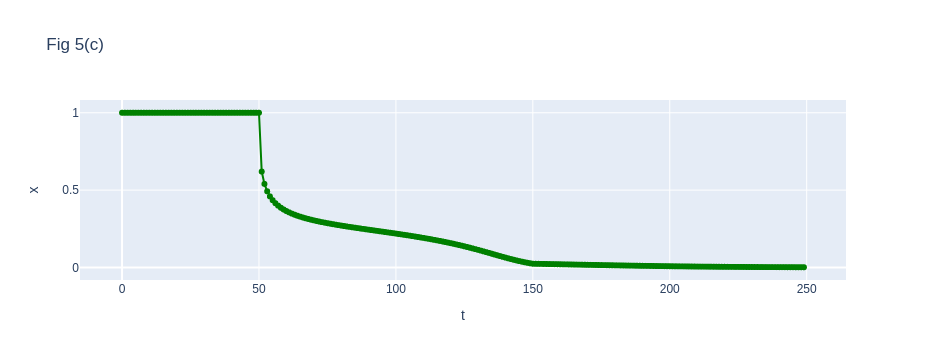

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts, y=xs_smart_protocol, mode='lines+markers', line=dict(color="green"), name = ""))
fig.update_layout(title="Fig 5(c)")
fig.update_layout(xaxis={"title": "t"}, yaxis={"title": "x"})